In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [3]:
!unzip -q license-plate-dataset.zip -d data

In [4]:
pip -q install scikeras

In [5]:
pip -q install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [6]:
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import shutil
import random
from sklearn.model_selection import train_test_split

# data import and exploration

In [7]:
#data paths
image_dir = 'data/archive/images/train'
label_dir = 'data/archive/labels/train'

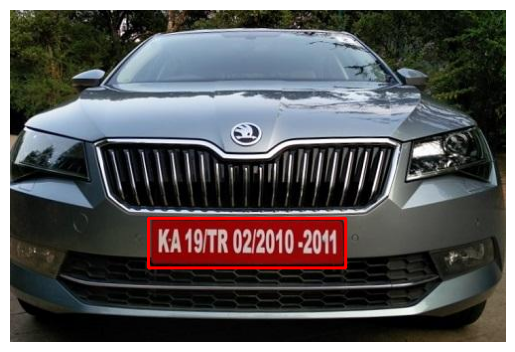

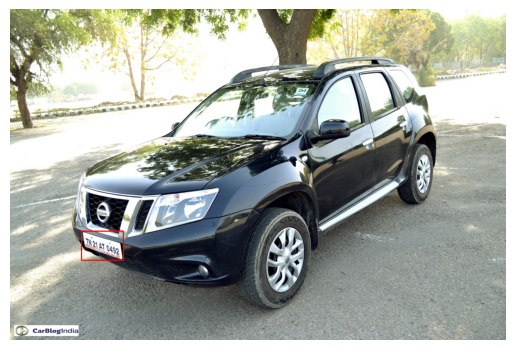

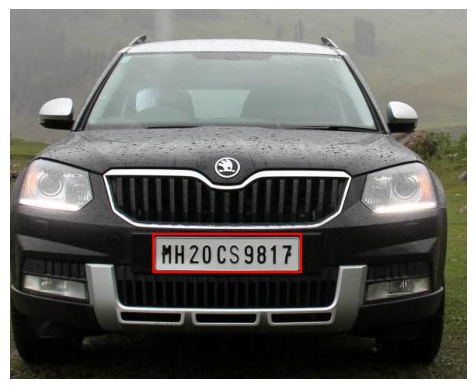

In [8]:
#deal with label paths that end in '.txt.txt'
def clean_label_path(label_path):
    if label_path.endswith('.txt.txt'):
        return label_path.replace('.txt.txt', '.txt')
    return label_path

#show images with boxes
def show_images_with_boxes(image_path, label_path, return_img= False):
  label_path= clean_label_path(label_path)
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _= img.shape

  with open(label_path, 'r') as f:
    boxes= f.readlines()

  for box in boxes:
    class_id, x_center, y_center, box_w, box_h= map(float, box.strip().split())
    x1= int((x_center - box_w / 2) *w)
    y1= int((y_center - box_h / 2) *h)
    x2= int((x_center + box_w / 2) *w)
    y2= int((y_center + box_h / 2) *h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

  if return_img:
    return img
  else:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#show some examples
sample_imgs= sorted(os.listdir(image_dir))[:3]

for img_file in sample_imgs:
  label_file= os.path.splitext(img_file)[0] + '.txt'
  label_path= os.path.join(label_dir, label_file)
  image_path= os.path.join(image_dir, img_file)

  show_images_with_boxes(image_path, label_path)

In [9]:
#count the images in each directory
train_imgs= glob('data/archive/images/train/*.jpg')
train_labels= glob('data/archive/labels/train/*.txt')
val_imgs= glob('data/archive/images/val/*.jpg')
val_labels= glob('data/archive/labels/val/*.txt')

print('Train images:', len(train_imgs))
print('Train labels:', len(train_labels))
print('Validation images:', len(val_imgs))
print('Validation labels:', len(val_labels))

Train images: 1526
Train labels: 1526
Validation images: 169
Validation labels: 169


In [10]:
#make sure every image has a matching label file
def check_missing_labels(img_paths, label_dir):
    missing= []
    for img_path in img_paths:
        base= os.path.splitext(os.path.basename(img_path))[0]
        label_path= os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label_path):
            missing.append(img_path)
    return missing

missing_train= check_missing_labels(train_imgs, 'data/archive/labels/train')
missing_val= check_missing_labels(val_imgs, 'data/archive/labels/val')

print(f"Missing labels in training set: {len(missing_train)}")
print(f"Missing labels in validation set: {len(missing_val)}")

Missing labels in training set: 0
Missing labels in validation set: 0


In [11]:
#check out bounding box size distribution
def get_bbox_dims(label_files):
    widths= []
    heights= []
    for lbl in label_files:
        with open(lbl, 'r') as f:
            for line in f.readlines():
                parts= line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h= map(float, parts)
                    widths.append(w)
                    heights.append(h)
    return pd.DataFrame({'width': widths, 'height': heights})

bbox_df= get_bbox_dims(train_labels + val_labels)
bbox_df.describe()

,width,height
count,1695.000000,1695.000000
mean,0.288975,0.103054
std,0.117831,0.076331
min,0.051471,0.021452
25%,0.216295,0.057851
50%,0.272059,0.082589
75%,0.337444,0.123077
max,0.996667,0.934483


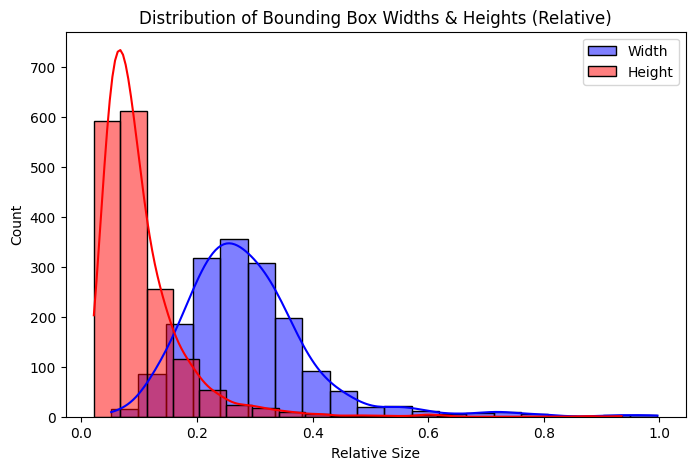

In [12]:
#plot the bounding box distribution
plt.figure(figsize=(8, 5))
sns.histplot(bbox_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(bbox_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Widths & Heights (Relative)")
plt.xlabel("Relative Size")
plt.legend()
plt.show()

In [13]:
#inspect distribution of image sizes
def get_image_sizes(image_paths):
    widths= []
    heights= []
    for path in tqdm(image_paths):
      with Image.open(path) as img:
        w, h= img.size
        widths.append(w)
        heights.append(h)

    return pd.DataFrame({'width': widths, 'height': heights})

all_imgs= train_imgs + val_imgs
img_dims_df= get_image_sizes(all_imgs)

print(img_dims_df.describe())

100%|██████████| 1695/1695 [00:00<00:00, 10414.81it/s]

             width       height
count  1695.000000  1695.000000
mean    654.546313   554.525664
std     499.585320   321.803263
min      78.000000    87.000000
25%     272.000000   333.000000
50%     485.000000   451.000000
75%     859.500000   734.000000
max    4000.000000  3000.000000


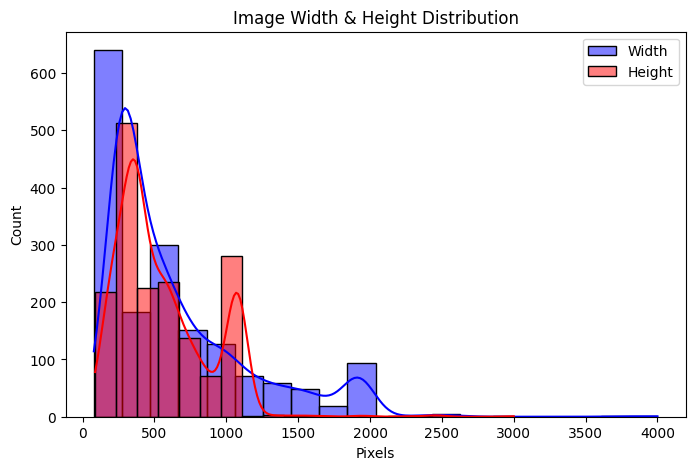

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(img_dims_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(img_dims_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Image Width & Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()

In [15]:
#check out the class distribution to confirm they are all "license plate"
with open("data/archive/classes.txt", "r") as f:
    classes= f.read().splitlines()

print(f"Classes ({len(classes)}): {classes}")

Classes (1): ['license_plate']


# data preprocessing

## letterbox resizing (padded resize)

In [16]:
#define input and output file paths
input_img_dir= "data/archive/images/train"
input_lbl_dir= "data/archive/labels/train"

output_img_dir= "data/processed/images"
output_lbl_dir= "data/processed/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

In [17]:
#define target dimensions
target_w= 620
target_h= 512

In [27]:
#function to resize the images
def letterbox_resize(image, target_width, target_height):
    h, w= image.shape[:2]
    scale= min(target_width / w, target_height / h)
    new_w= int(w * scale)
    new_h= int(h * scale)

    resized= cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pad_w= target_width - new_w
    pad_h= target_height - new_h
    top= pad_h // 2
    bottom= pad_h - top
    left= pad_w // 2
    right= pad_w - left

    padded= cv2.copyMakeBorder(resized,
                                top,
                                bottom,
                                left,
                                right,
                                cv2.BORDER_CONSTANT,
                                value=(114, 114, 114))

    return padded, scale, left, top, w, h

#function to resize the labels
def process_labels(label_path, scale, pad_left, pad_top, orig_w, orig_h):
    new_lines= []

    with open(label_path, 'r') as f:
        lines= f.readlines()

    for line in lines:
        class_id, x, y, w, h= map(float, line.strip().split())

        #undo YOLO normalization
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h

        #scale
        x *= scale
        y *= scale
        w *= scale
        h *= scale

        #add padding offset
        x += pad_left
        y += pad_top

        #re-normalize
        x /= target_w
        y /= target_h
        w /= target_w
        h /= target_h

        new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    return new_lines

#function to preprocess data subset
def preprocess_yolo_dataset(input_img_dir,
                            input_lbl_dir,
                            output_img_dir,
                            output_lbl_dir,
                            target_w=640,
                            target_h=512):

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_files= [f for f in os.listdir(input_img_dir)
                 if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc=f"Preprocessing {os.path.basename(input_img_dir)}"):
        img_path= os.path.join(input_img_dir, img_file)
        label_filename= os.path.splitext(img_file)[0] + '.txt'
        label_path= os.path.join(input_lbl_dir, label_filename)

        image = cv2.imread(img_path)

        pad_img, scale, pad_left, pad_top, orig_w, orig_h= letterbox_resize(image,
                                                                            target_w,
                                                                            target_h)

        #save the padded image
        out_img_path= os.path.join(output_img_dir, img_file)
        cv2.imwrite(out_img_path, pad_img)

        #process and save image
        if os.path.exists(label_path):
            new_label_lines = process_labels(label_path,
                                             scale,
                                             pad_left,
                                             pad_top,
                                             orig_w,
                                             orig_h)

            out_lbl_path = os.path.join(output_lbl_dir,
                                        label_filename)

            with open(out_lbl_path, 'w') as f:
                f.write('\n'.join(new_label_lines))

In [28]:
#preprocess the train subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/train',
    input_lbl_dir= 'data/archive/labels/train',
    output_img_dir= 'data/processed/images',
    output_lbl_dir= 'data/processed/labels')

#preprocess the validation subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/val',
    input_lbl_dir= 'data/archive/labels/val',
    output_img_dir= 'data/processed_val/images',
    output_lbl_dir= 'data/processed_val/labels')

Preprocessing val: 100%|██████████| 169/169 [00:02<00:00, 64.90it/s]


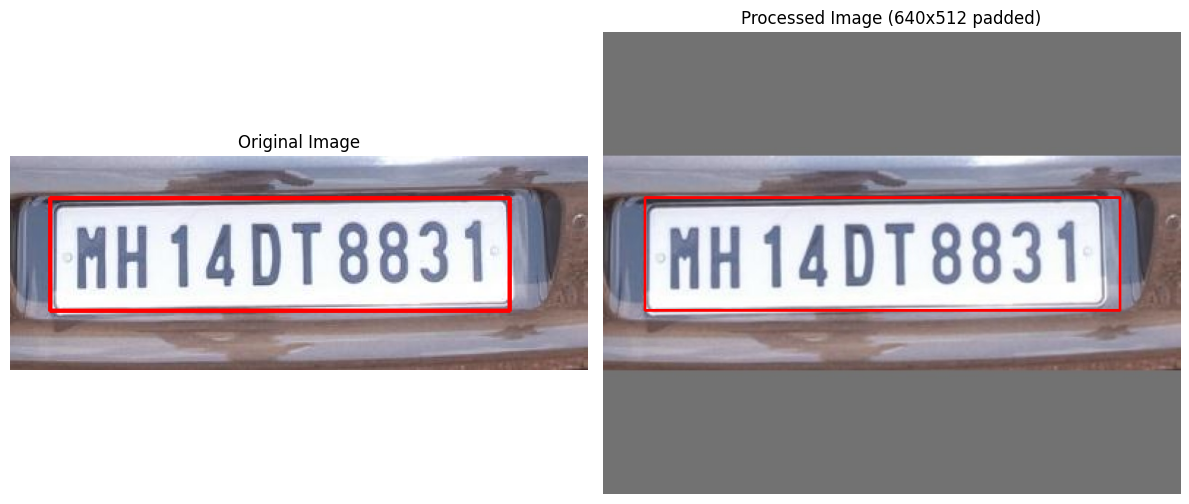

In [29]:
#create function to show image and bounding box before and after transformation
def show_images_side_by_side(img1_path, lbl1_path, img2_path, lbl2_path):
    img1= show_images_with_boxes(img1_path, lbl1_path, return_img=True)
    img2= show_images_with_boxes(img2_path, lbl2_path, return_img=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Processed Image (640x512 padded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#show before and after example from subset of uncomplicated file names
image_files= [f for f in os.listdir(input_img_dir) if f.lower().endswith('.jpg')]
trans_example= sorted(image_files)[8]
#fix label name edge cases
label_filename= os.path.splitext(trans_example)[0] + '.txt'


show_images_side_by_side(os.path.join(input_img_dir, trans_example),
                         os.path.join(input_lbl_dir, label_filename),
                         os.path.join(output_img_dir, trans_example),
                         os.path.join(output_lbl_dir, label_filename))

# Train Val Test Split